# RNA Velocity Analysis (Language: Python)

This tutorial is a quick dive into RNA Velocity analysis. *RNA velocity* - the time derivative of the gene expression state - can be directly estimated by distinguishing between unspliced and spliced mRNAs in common scRNA-seq protocols, and is a useful tool in analyzing developmental lineages and cellular dynamics. Check out the original publication by [La Manno et al. (Nature, 2018)](https://doi.org/10.1038/s41586-018-0414-6).

This notebook follows the [*RNA Velocity Basics* tutorial](https://scvelo.readthedocs.io/VelocityBasics/) provided by `scVelo` ([Bergen et al. (Nature Biotechnology, 2020)](https://doi.org/10.1038/s41587-020-0591-3)), a scalable toolkit for RNA velocity analysis in single cells which is compatible with scanpy. We highly recommend that you check out the original tutorial, as it covers the concepts underlying RNA velocity in more depth, and also discusses more advanced analysis you can do using the `scVelo` toolkit.  

In order to perform RNA velocity analysis with your own data, you will need access to a compute cluster. Upstream processing pipelines like [`velocyto`](https://velocyto.org/velocyto.py/index.html) require a genome annotation file (.gtf file), as well as files that are generated by running a counting pipeline like Cell Ranger (the *barcodes.tsv.gz* file and the *possorted_genome_bam.bam* file). As output, `velocyto` generates two count matrices of pre-mature (unspliced) and mature (spliced) transcript abundances, which are used for downstream processing by scVelo. These are usually stored in a *.loom* file.

Because we can't run RNA velocity on our own datasets in the context of this workshop, we will use a built-in sample dataset provided by scVelo. If you do happen to have an accompanying velocyto *.loom* file with your dataset, you can used the following lines of code to read in your *.loom* file and merge it with your processed *AnnData* object, adata:
```
velocyto_data = scv.read('PATH-TO-YOUR-LOOM-FILE.loom', cache=True)
adata = scv.utils.merge(adata, velocyto_data)
```

The rest of the steps will be the same whether you are using the built-in dataset or your own!

# Table of Contents

* [1 Pseudotime Analysis and RNA Velocity](#1-Pseudotime-Analysis-and-RNA-Velocity)
* [2 Setting Up the Coding Environment](#2-Setting-Up-the-Coding-Environment)
* [3 Reading in the Data](#3-Reading-in-the-Data)
* [4 Preprocess the Data](#4-Preprocess-the-Data)
* [5 Estimate RNA Velocity](#5-Estimate-RNA-Velocity)
* [6 Interpret the Velocities](#6-Interpret-the-Velocities)
* [7 Identify Important Genes](#7-Identify-Important-Genes)
* [8 Pseudotime and PAGA Velocity Graph](#8-Pseudotime-and-PAGA-Velocity-Graph)

# 1 Pseudotime Analysis and RNA Velocity

**What is pseudotime analysis?**</br>
Pseudotime analysis (also called pseudotime inference or trajectory inference) aims to infer the ordering of cells along a lineage based on gene expression profiles measured by scRNA-seq. Pseudotime is a time-like variable, which indicates the relative position a cell takes in a lineage (in other words, pseudotime is the distance between a cell and the start of the trajectory, measured along the shortest path). Remember, your typical scRNA-seq is static, i.e. the cells were collected at one single timepoint. However, in your scRNA-seq dataset there are cells that are representative of different stages of differentiation and development. Therefore, by establishing a temporal dimension in a static scRNA-seq dataset, we can look at the expression dynamics of individual genes along with continuous cell-state changes, and measure how much progress an individual cell has made through a process such as cell differentiaion.

There are many methods used to perform pseudotime and trajectory inference. Check out [*dynverse*](https://dynverse.org/), a collection of R packages aimed at supporting the trajectory inference community, which offers a catalog of various methods as well as comparisons between the various methods so you can pick the right tool for your dataset. 

**What is RNA velocity?**</br>
RNA velocity is a particular kind of pseudotime analysis based on the concept that, while the exonic transcriptome represents the current state of a cell, the intronic transcriptome represents what the cell is going to be in the near future. As described by La Manno and colleagues, RNA velocity describes the direction and speed with which cells could transition between clusterstates and also may indicate the direction that cells within individual clusters may by likely to follow at various branching points. For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are the residuals of this ratio. A positive velocity indicates that a gene is up-regulated (higher abundance of unspliced mRNA for that gene than expected in steady state), while a negative velocity indicates that a gene is down-regulated.  

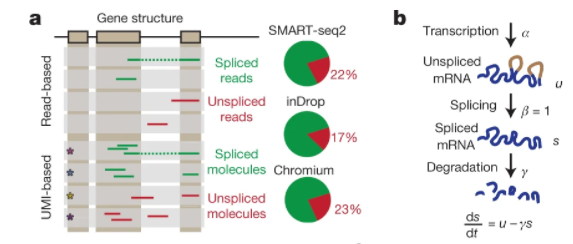  
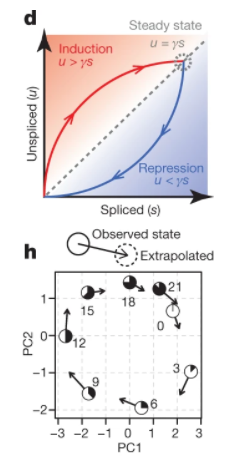  

**How do I use trajectory inference and RNA velocity in my workflow?**</br>
Pseudotime and trajectory inference methods are applied to reduced and corrected data after dimensionality reduction and clustering. Clusters in inferred trajectories may represent stable or metastable states (dense regions along a trajectory, which indicate preferred transcriptomic states). Because multiple biological processes are typically occurring simultaneously within cells, it might be useful to regress out biological effects of other processes (such as cell cycle) to isolate the expected trajectory. RNA velocities can subsequently be overlayed onto the trajectory to add dimensionality and support. In fact, no matter which pseudotime method you use, it is always best to validate the results of one pseudotime analysis method by using a second independent pseudotime analysis method. For instance, you could use both `slingshot` and RNA velocity to look at trajectory structures, and if you see the same trajectory structures in both methods then that supports that you are seeing something reflective of true biology.

# 2 Setting Up the Coding Environment

Just like in our previous two tutorials, we need to set up our jupyter notebook and load in all of the python modules, packages, and libraries we need for RNA velocity analysis. Here, we will primarily be working with the `scVelo` toolkit.

In [1]:
# main RNA velocity analysis toolkit
import scvelo as scv

import scanpy as sc

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
# Files and Directories
scv.settings.figdir = './figures/'

# 3 Reading in the Data

We will be using scVelo's built-in pancreas dataset, which we can use to explore endocrine development and lineage commitment to four major fates: α, β, δ and ε-cells. Because this is a built-in dataset, it is easy to load in the data:

In [4]:
# load in the pancreas dataset
adata = scv.datasets.pancreas()

If we look at our adata object, you'll see it has a lot of annotations that we are used to seeing after our preprocessing and clustering tutorials. However, we now have two new layers: *spliced* and *unspliced*, which store our spliced and unspliced counts matrices.

In [5]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Since this is a new (preprocessed and annotated) dataset for us, let's go ahead and use to scanpy to plot the UMAP (we know this dataset has UMAP coordinates because when we look at our adata object, we can see 'X_umap' listed under .obsm). This will let us easily see the cell types that we are working with.

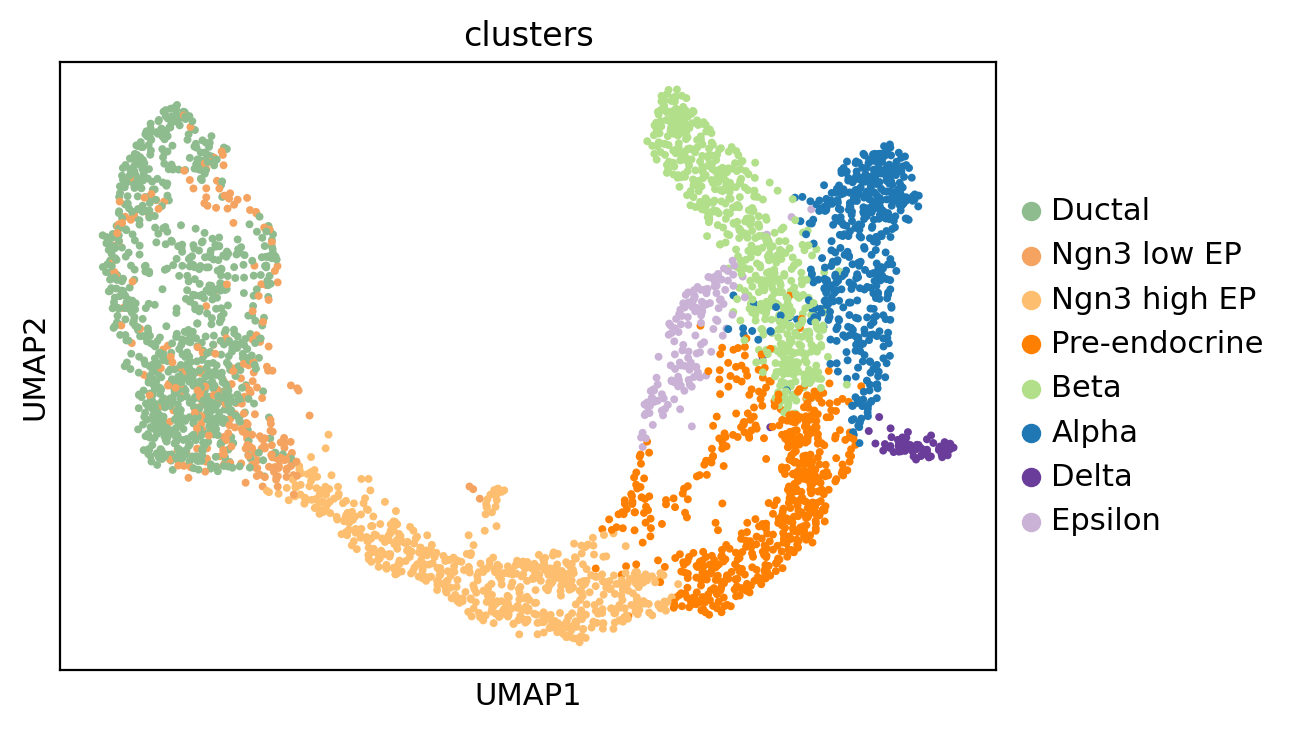

In [6]:
sc.pl.umap(adata, color='clusters')

We can also plot the proportions of spliced/unspliced counts in our data. Depending on the scRNA-seq protocol used, we will typically have between 10-25% of unspliced molecules containing intronic sequences. By looking the spliced/unspliced counts information per cluster, we can verify that we have consistency in splicing efficiency across all cell types.

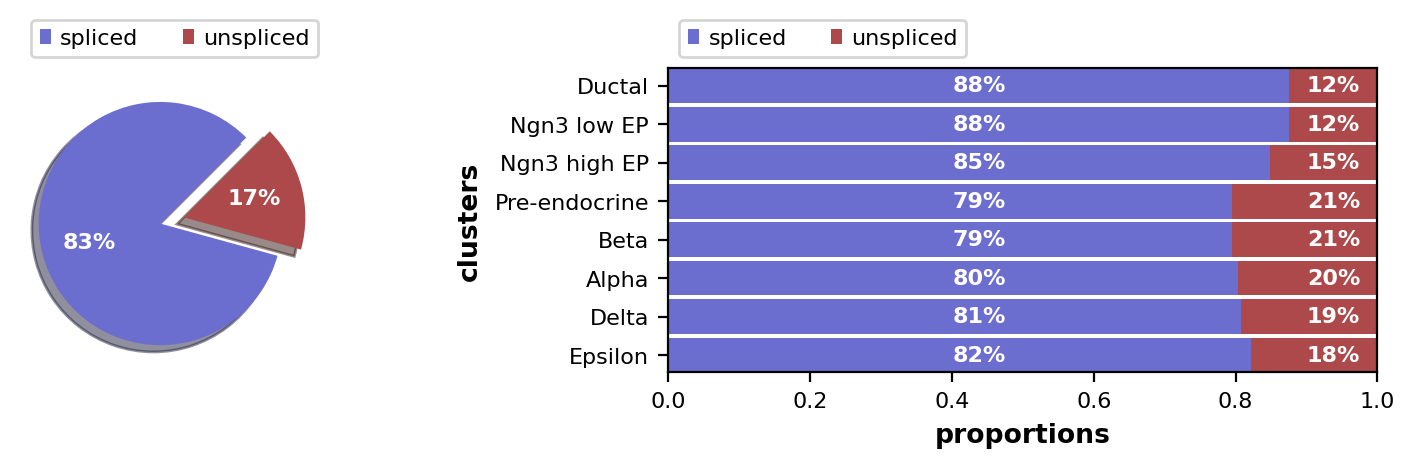

In [7]:
scv.pl.proportions(adata)

In this example, we have slight variations as expected. There are slightly lower unspliced proportions in the ductal cells (which are cycling), and higher unspliced proportions at cell fate commitment in Ngn3-high and Pre-endocrine cells (where many genes start to be transcribed).

# 4 Preprocess the Data

Just like how we had to preprocess our standard transcriptome data, we also have to preprocess our RNA velocity data. This includes gene selection by detection (with a minimum number of counts) and high variability, normalizing every cell by its total size and logarithmizing our counts (stored in *adata.X*). Filtering and normalization is applied to the spliced/unspliced counts as well as the total counts stored in *adata.X*. However, logarithmizing is only applied to the counts stored in *adata.X*. If you are working with an adata object that has already been preprocessed (following the steps in the preprocess and cluster analysis tutorials), then *adata.X* will not be changed at this step (since it has already been preprocessed).

All of these steps can be done with a single function in scVelo:

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


Next, we need to compute the first (mean) and second (variance) order moments among nearest neighbors in PCA space. First order moments are needed for deterministic velocity estimation (the output of the model is fully determined by the parameter values and initial conditions), while stochastic estimation (possess some inherent randomness) also requires second order moments.

In [9]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# 5 Estimate RNA Velocity

Now we will compute our velocities. RNA velocites are vectors in gene expression space and represent the direction and speed of movement of individual cells. Velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default; requires first and second order moments) or deterministically (requires first order moments only). The computed velocities are stored in *adata.layers*, just like count matrices.

In [10]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated (for each velocity vector, we find the likely cell transitions that are accordance with that direction). The transition probabilities are stored in a matrix called the velocity graph, which summarizes the possible cell state changes that are well explained through the velocity vectors.

In [11]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


After calculating our velocity graph matrix, we can project the velocities onto any embedding (tSNE, UMAP, etc.). Velocities can be visualized in a couple different ways. In this first plot, we are looking at the velocities as streamlines:

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


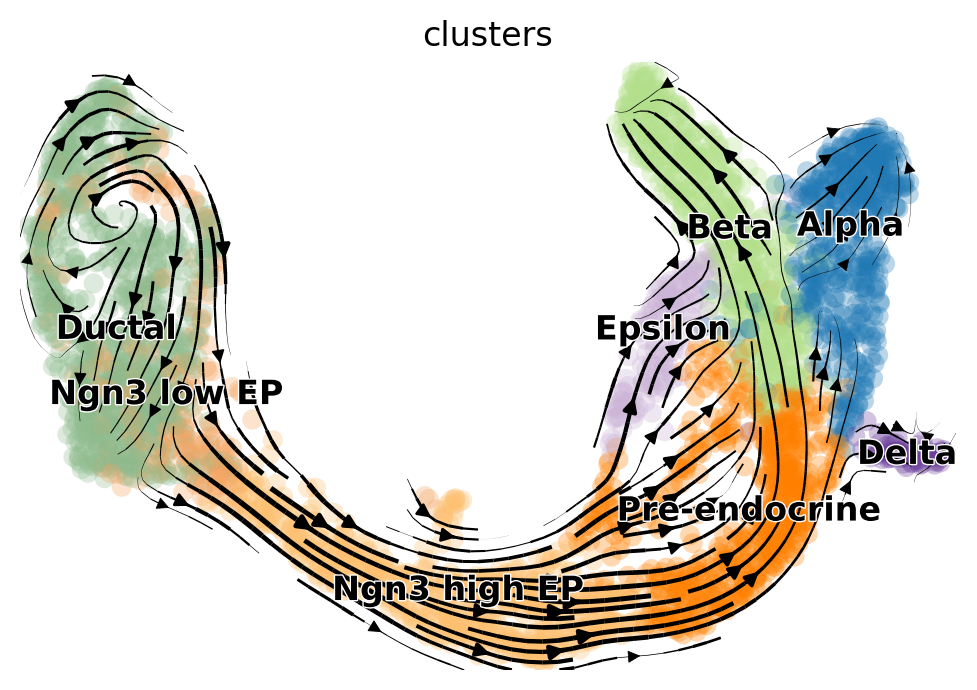

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

Streamlines can yield fine-grained insights into developmental processes. For instance, the streamlines in the above plot accurately delineate the cycling population of ductal cells and endocrine progenitors. The streamlines also illuminate cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation. 

In this second plot, we are looking at the same velocities, but visualized on the cellular level:

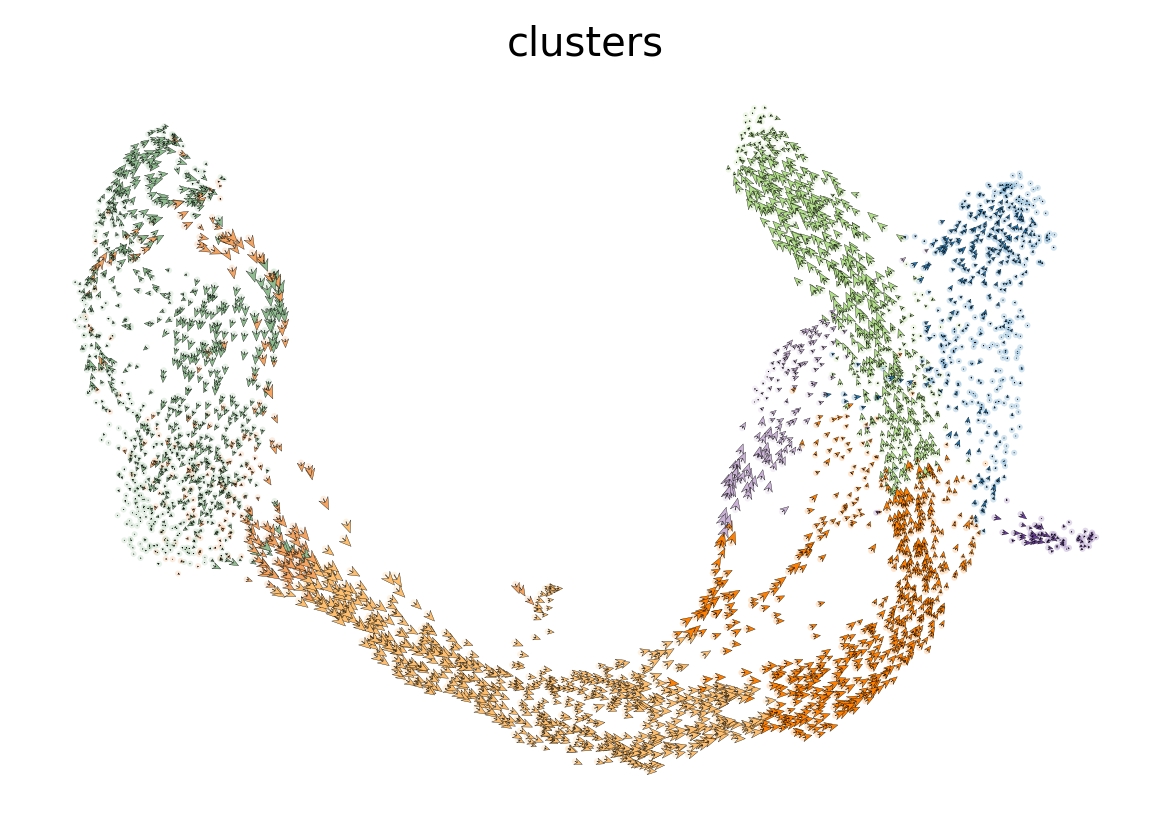

In [13]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

Here, each arrow shows the direction and speed of movement of an individual cell, which is the most fine-grained resolution of the velocity vector field we can get at single-cell level.

# 6 Interpret the Velocities

In this next section, we will look at individual gene dynamics via phase portraits to understand how inferred velocity directions are supported by particular genes.

Remember, RNA velocity for a particular gene is determined as the residual (how much an observation deviates) of the steady-state ratio (the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state). Posivite velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

In the phase portraits below (the rectangular plots on the lefthand side of the panels), the black dotted line corresponds to the estimated steady-state ratio:

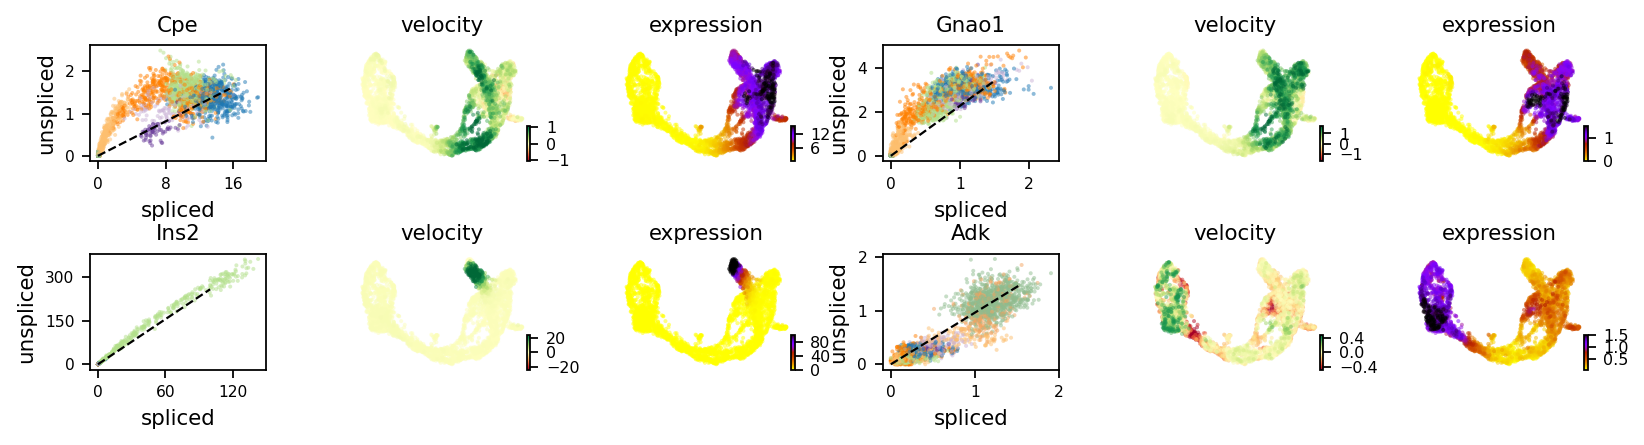

In [14]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In this example, *Cpe* explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while *Adk* explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

# 7 Identify Important Genes

To help us identify genes that might explain the resulting vector field and inferred lineages, we can use scVelo to test which genes have cluster-specific differential velocity expression (being significantly higher or lower compared to the remaining population).

In [15]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
0,Notch2,Ptpn3,Pde1c,Pam,Pax6,Zcchc16,Zdbf2,Tmcc3
1,Sox5,Hacd1,Ptprs,Sdk1,Unc5c,Nlgn1,Spock3,Heg1
2,Krt19,Hspa8,Pclo,Baiap3,Nnat,Nell1,Akr1c19,Gpr179
3,Hspa8,Gm8113,Rap1gap2,Abcc8,Tmem108,Prune2,Ptprt,Ica1
4,Ano6,Kcnq1,Ttyh2,Gnas,Ptprt,Ksr2,Snap25,Ncoa7


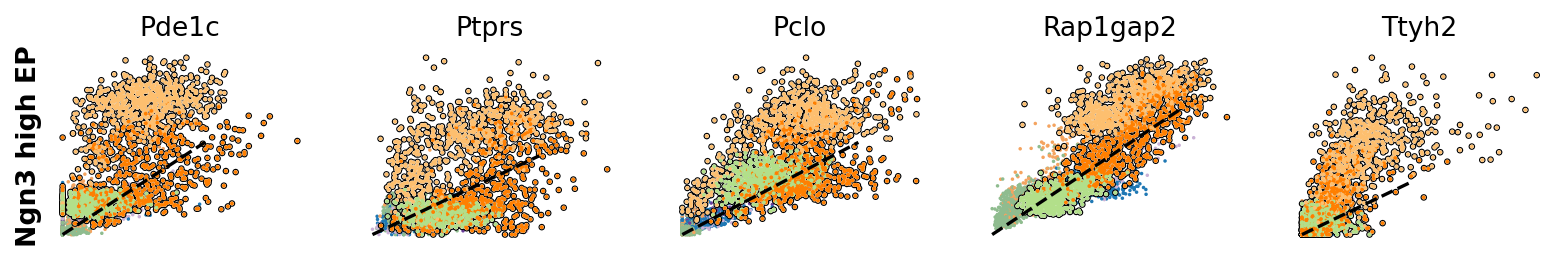

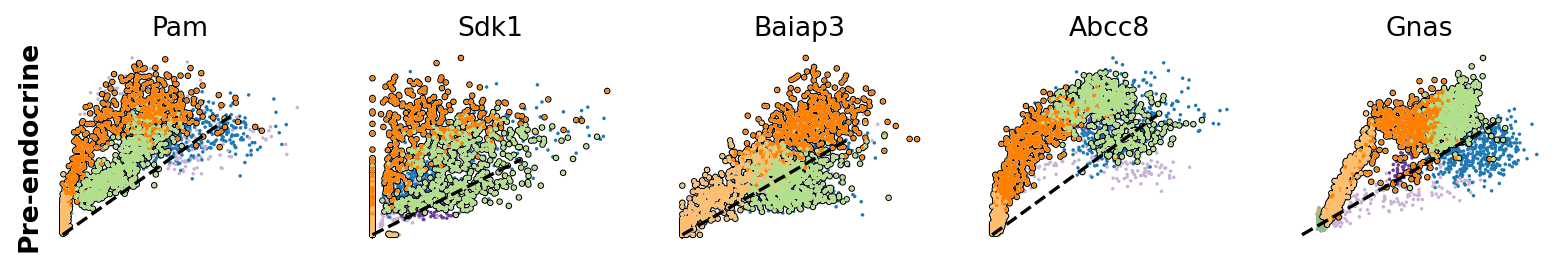

In [16]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

The genes Ptprs, Pclo, Pam, Abcc8, Gnas, for instance, support the directionality from Ngn3 high EP (yellow) to Pre-endocrine (orange) to Beta (green).

# 8 Pseudotime and PAGA Velocity Graph

Based on the velocity graph, a *velocity pseudotime* can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells.

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


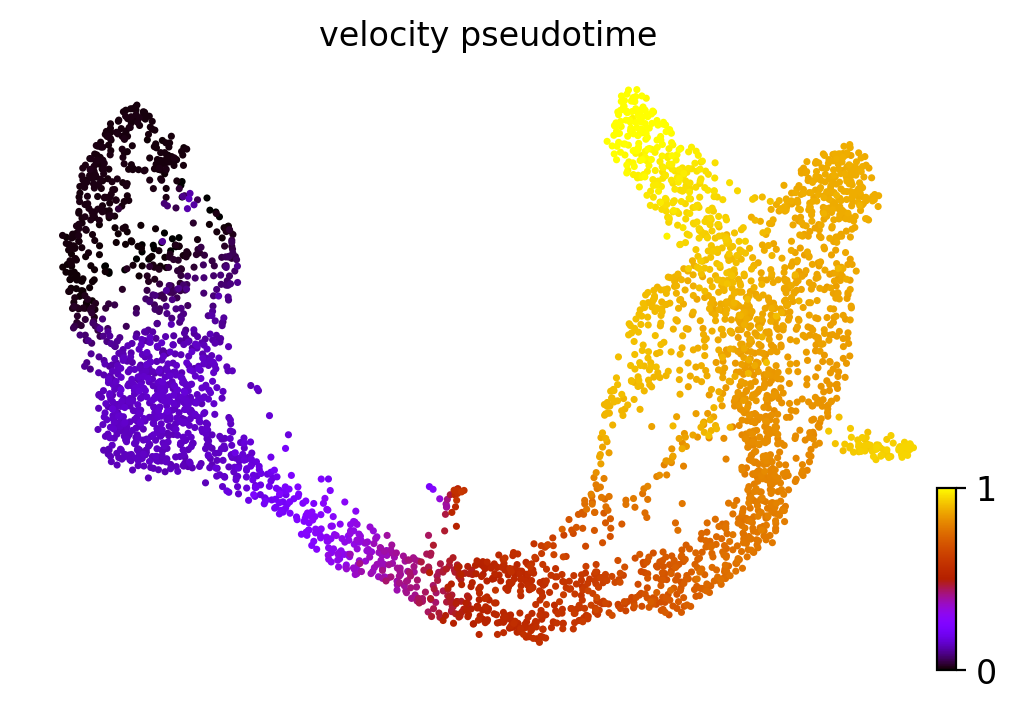

In [17]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

One last cool thing we can do with scVelo. We can use PAGA graph abstraction to provide a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters.

In [18]:
scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
Ductal,0,0.15,0,0,0,0,0,0
Ngn3 low EP,0,0,0.24,0,0,0,0,0
Ngn3 high EP,0,0,0,0.23,0,0,0,0
Pre-endocrine,0,0,0,0,0.5,0.12,0.21,0.12
Beta,0,0,0,0,0,0,0,0
Alpha,0,0,0,0,0,0,0,0
Delta,0,0,0,0,0,0,0,0
Epsilon,0,0,0,0,0,0,0,0


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP.

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

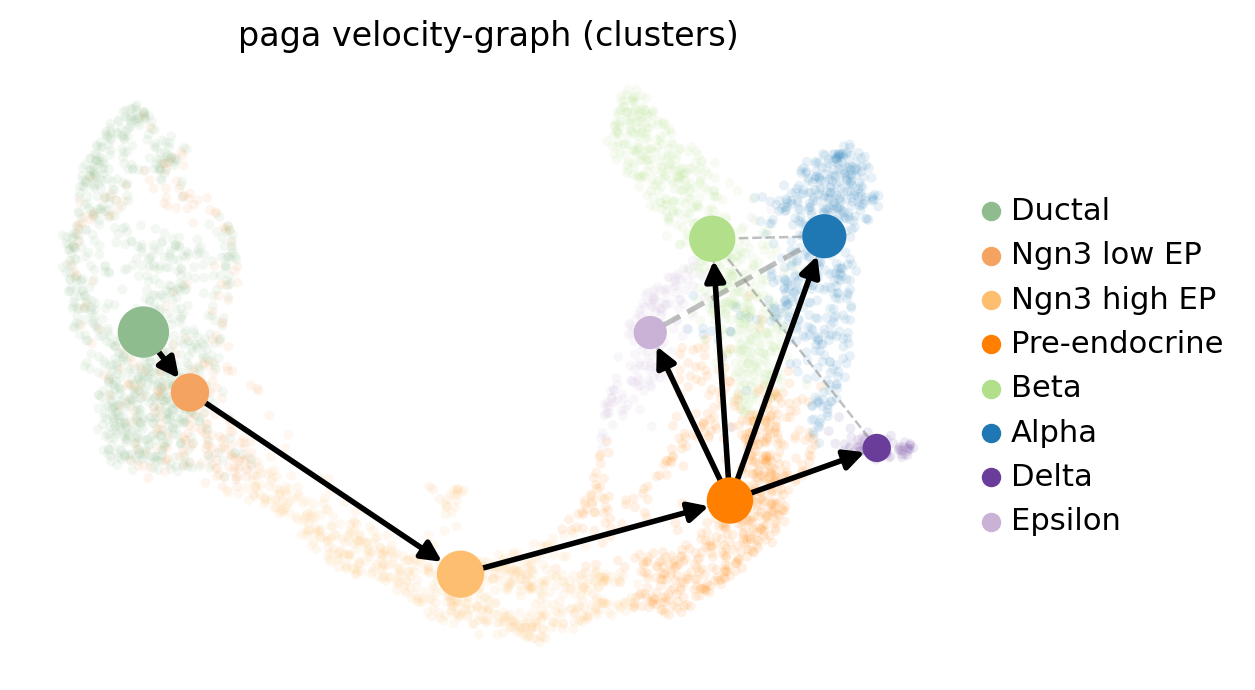

In [19]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)